In [1]:
import os
os.chdir("/zhome/be/1/138857/EHR_sensor_representations/scripts")  

In [2]:
import sys
import os
from mortality_part_preprocessing import load_pad_separate
from mortality_part_preprocessing import MortalityDataset, PairedDataset
from models.regular_transformer import EncoderClassifierRegular
from models.early_stopper import EarlyStopping
from models.deep_set_attention import DeepSetAttentionModel
from models.grud import GRUDModel
from models.ip_nets import InterpolationPredictionModel
from torch.utils.data import DataLoader
import tqdm
import torch
import torch.nn as nn

In [15]:
import numpy as np
file = "normalization_physionet2012_1.json"
path = "/zhome/be/1/138857/EHR_sensor_representations/scripts/P12data/"
import json
with open(path + file, "r") as f:
    norm_data = json.load(f)
# Print time-series feature names
print(type(norm_data["ts_means"]))  # Should print <class 'list'>
print(len(norm_data["ts_means"]))   # How many elements?
print(norm_data["ts_means"][:5])    

<class 'list'>
37
[83.11079574756315, 119.44102735156771, 359.6545383880742, 513.2573910788382, 2.894396249926148]


In [6]:
dataset_id = "physionet2012"  # Change this if needed
base_path = "/zhome/be/1/138857/EHR_sensor_representations/scripts/P12data/split_1"  # Path to extracted files
split_index = 1  # Choose the dataset split
save_path = "./processed_datasets"  # Where the preprocessed data will be stored

# Load the dataset
mortality_pair, mortality_val, mortality_test = load_pad_separate(
    dataset_id, base_path, split_index, save_path
)

Loading preprocessed datasets from ./processed_datasets
Loaded dataset from ./processed_datasets/physionet2012_1_pos.h5
Loaded dataset from ./processed_datasets/physionet2012_1_neg.h5
Loaded dataset from ./processed_datasets/physionet2012_1_val.h5
Loaded dataset from ./processed_datasets/physionet2012_1_test.h5


In [ ]:
batch_size = 64
train_pair = mortality_pair
train_batch_size = batch_size // 2 

train_collate_fn = PairedDataset.paired_collate_fn_truncate
train_dataloader = DataLoader(train_pair, train_batch_size, shuffle=True, num_workers=16, collate_fn=train_collate_fn, pin_memory=True)
train_dataloader = DataLoader(train_pair, train_batch_size, shuffle=True, num_workers=16, collate_fn=train_collate_fn, pin_memory=True)

In [5]:
train_dataloader

In [ ]:
c = 0 
for batch in tqdm.tqdm(train_dataloader, total=len(train_dataloader)):
    c += 1
    if c < 2:
        data, times, static, labels, mask, delta = batch
        print(data)
    else:
        break 

In [9]:
def get_one_hot_features(num_features, batch_size, time_steps, device):
    """
    Creates a one-hot encoding matrix for all features and generates corresponding mask and delta.

    Args:
    - num_features (int): Number of original features in X.
    - batch_size (int): Number of samples in the batch.
    - time_steps (int): Number of time steps (sequence length).
    - device (str): CUDA or CPU device.

    Returns:
    - feature_one_hot (torch.Tensor): One-hot encoded feature matrix.
    - one_hot_mask (torch.Tensor): Corresponding mask for one-hot features.
    - one_hot_delta (torch.Tensor): Corresponding delta values (zero since one-hot is static).
    """

    # Identity matrix for one-hot encoding (F, F)
    feature_one_hot = torch.eye(num_features, device=device)  # Shape: (F, F)

    # Expand to match batch and time dimensions
    feature_one_hot = feature_one_hot.unsqueeze(0).unsqueeze(2)  # Shape: (1, F, 1, F)
    feature_one_hot = feature_one_hot.expand(batch_size, -1, time_steps, -1)  # Shape: (B, F, T, F)

    # Reshape for concatenation with data (flatten the one-hot encoding)
    feature_one_hot = feature_one_hot.reshape(batch_size, num_features * num_features, time_steps)  # (B, F*F, T)

    # Create a corresponding mask (1s for all one-hot encoded features)
    one_hot_mask = torch.ones_like(feature_one_hot, dtype=torch.float32, device=device)  # (B, F*F, T)

    # Create a corresponding delta (0s since one-hot encoding does not change over time)
    one_hot_delta = torch.zeros_like(feature_one_hot, dtype=torch.float32, device=device)  # (B, F*F, T)

    return feature_one_hot, one_hot_mask, one_hot_delta


def train(
    train_dataloader,
    val_dataloader,
    output_path,
    epochs,
    patience,
    device,
    model_type,
    lr,
    early_stop_criteria,
    model_args,
    expand_features=True,  # NEW: Toggle one-hot encoding
    **kwargs,  
):
    """
    Training function with an option to expand feature space using one-hot encoding.
    """

    # assign GPU
    if torch.cuda.is_available():
        dev = "cuda"
    else:
        dev = "cpu"
    device = torch.device(dev)
    
    iterable_inner_dataloader = iter(train_dataloader)
    test_batch = next(iterable_inner_dataloader)
    max_seq_length = test_batch[0].shape[2]  # Time steps (T)
    sensor_count = test_batch[0].shape[1]  # Features (F)
    static_size = test_batch[2].shape[1]  # Static feature size

    # Define the model
    if model_type == "grud":
        model = GRUDModel(
            input_dim=sensor_count + (sensor_count * sensor_count if expand_features else 0),  # Adjust for expanded input
            static_dim=static_size,
            output_dims=2,
            device=device,
            recurrent_n_units=128,  #ADDED
            recurrent_dropout=0.3, #ADDED 
            dropout=0.0, #ADDED 
            **model_args
        )
    elif model_type == "ipnets":
        model = InterpolationPredictionModel(
            output_dims=2,
            sensor_count=sensor_count + (sensor_count if expand_features else 0),  # Adjust for expanded input
            **model_args
        )
    elif model_type == "seft":
        model = DeepSetAttentionModel(
            output_activation=None,
            n_modalities=sensor_count + (sensor_count if expand_features else 0),
            output_dims=2,
            **model_args
        )
    elif model_type == "transformer":
        model = EncoderClassifierRegular(
            num_classes=2,
            device=device,
            max_timepoint_count=max_seq_length,
            sensors_count=sensor_count + (sensor_count if expand_features else 0),
            static_count=static_size,
            return_intermediates=False,
            **model_args
        )

    criterion = nn.CrossEntropyLoss()  # Loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    early_stopping = EarlyStopping(
        patience=patience, verbose=True, path=f"{output_path}/checkpoint.pt"
    )  

    # Training loop
    for epoch in range(epochs):
        model.train().to(device)
        loss_list = []

        c = 0 
        for batch in tqdm.tqdm(train_dataloader, total=len(train_dataloader)):

            data, times, static, labels, mask, delta = batch

            # Create one-hot encoding for features and concatenate
            batch_size = data.shape[0]
           # Get expanded one-hot encoded features, mask, and delta
            one_hot_features, one_hot_mask, one_hot_delta = get_one_hot_features(sensor_count, batch_size, data.shape[2], device)

            # Concatenate one-hot encoding to data, mask, and delta
            data = torch.cat([data, one_hot_features], dim=1)
            mask = torch.cat([mask, one_hot_mask], dim=1)
            delta = torch.cat([delta, one_hot_delta], dim=1)

            if model_type != "grud":
                data = data.to(device)
                static = static.to(device)
                times = times.to(device)
                mask = mask.to(device)
                delta = delta.to(device)

            optimizer.zero_grad()

            predictions = model(
                x=data, static=static, time=times, sensor_mask=mask, delta=delta
            )
            predictions = predictions.squeeze(-1)
            loss = criterion(predictions.cpu(), labels)
            loss_list.append(loss.item())

            loss.backward()
            optimizer.step()

        accum_loss = np.mean(loss_list)

        # Validation step
        model.eval().to(device)
        labels_list = torch.LongTensor([])
        predictions_list = torch.FloatTensor([])

        with torch.no_grad():
            for batch in val_dataloader:
                data, times, static, labels, mask, delta = batch

                # Create one-hot encoding for features and concatenate
                batch_size = data.shape[0]
                one_hot_features, one_hot_mask, one_hot_delta = get_one_hot_features(sensor_count, batch_size, data.shape[2], device)

                # Concatenate one-hot encoding to data, mask, and delta
                data = torch.cat([data, one_hot_features], dim=1)
                mask = torch.cat([mask, one_hot_mask], dim=1)
                delta = torch.cat([delta, one_hot_delta], dim=1)

                if model_type != "grud":
                    data = data.to(device)
                    static = static.to(device)
                    times = times.to(device)
                    mask = mask.to(device)
                    delta = delta.to(device)

                predictions = model(
                    x=data, static=static, time=times, sensor_mask=mask, delta=delta
                )
                predictions = predictions.squeeze(-1)
                predictions_list = torch.cat((predictions_list, predictions.cpu()), dim=0)
        
        val_loss = criterion(predictions_list.cpu(), labels_list)

        print(f"Epoch: {epoch+1}, Train Loss: {accum_loss}, Val Loss: {val_loss}")

        if early_stop_criteria == "loss":
            early_stopping(val_loss, model)

        if early_stopping.early_stop:
            print("Early stopping")
            break

    return val_loss, model



In [10]:
dataset_id = "physionet2012"  # Change this if needed
base_path = "/zhome/be/1/138857/EHR_sensor_representations/scripts/P12data/split_1"  # Path to extracted files
split_index = 1  # Choose the dataset split
save_path = "./processed_datasets"  # Where the preprocessed data will be stored

# Load the dataset
train_pair, val, test = load_pad_separate(
    dataset_id, base_path, split_index, save_path
)

batch_size = 64 // 2

train_loader = DataLoader(train_pair, batch_size, shuffle=True, num_workers=16, collate_fn=PairedDataset.paired_collate_fn_truncate, pin_memory=True)
val_loader = DataLoader(val, batch_size, shuffle=True, num_workers=16, collate_fn=MortalityDataset.non_pair_collate_fn_truncate, pin_memory=True)

train_loss, trained_model = train(
    train_dataloader=train_loader,
    val_dataloader=val_loader,
    output_path="./results",
    epochs=2,
    patience=5,
    device="cuda",
    model_type="grud",
    lr=0.001,
    early_stop_criteria="loss",
    model_args={},
    expand_features=True  # Enable one-hot encoding
)


Loading preprocessed datasets from ./processed_datasets
Loaded dataset from ./processed_datasets/physionet2012_1_pos.h5
Loaded dataset from ./processed_datasets/physionet2012_1_neg.h5
Loaded dataset from ./processed_datasets/physionet2012_1_val.h5
Loaded dataset from ./processed_datasets/physionet2012_1_test.h5


 17%|██████████████████████▌                                                                                                          | 22/126 [00:55<04:23,  2.53s/it]


KeyboardInterrupt: 

In [33]:
37*37+37

1406

In [4]:
sensor_count = 37
expand_features = True
test = sensor_count + (sensor_count * sensor_count if expand_features else 0)
print(test)

1406


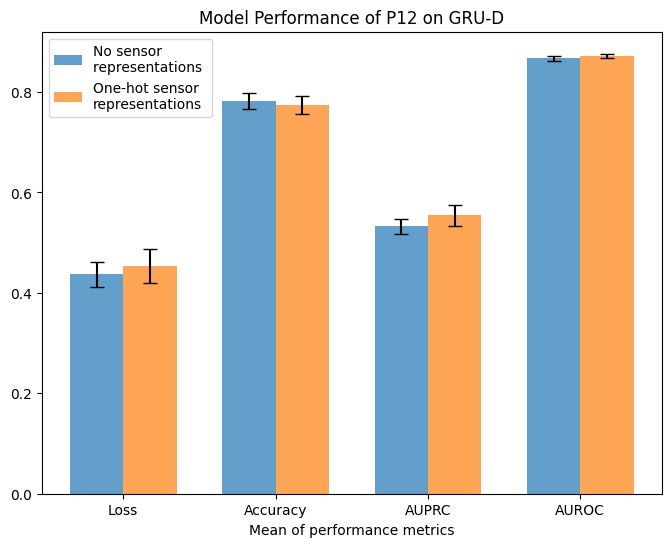

In [4]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load JSON data from two files
file1 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_3/summary.json"  # Replace with actual file name
file2 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_2/summary.json"  # Replace with actual file name

with open(file1, "r") as f:
    data1 = json.load(f)

with open(file2, "r") as f:
    data2 = json.load(f)

# Extract metrics
metrics = ["mean_loss", "mean_accuracy", "mean_auprc", "mean_auroc"]
std_metrics = ["std_loss", "std_accuracy", "std_auprc", "std_auroc"]

means1 = [data1[m] for m in metrics]
means2 = [data2[m] for m in metrics]

stds1 = [data1[s] for s in std_metrics]
stds2 = [data2[s] for s in std_metrics]

# Plot bar chart
x_labels = ["Loss", "Accuracy", "AUPRC", "AUROC"]
x = np.arange(len(metrics))
width = 0.35  # Bar width

fig, ax = plt.subplots(figsize=(8, 6))
bars1 = ax.bar(x - width/2, means1, width, yerr=stds1, capsize=5, label="No sensor \nrepresentations ", alpha=0.7)
bars2 = ax.bar(x + width/2, means2, width, yerr=stds2, capsize=5, label="One-hot sensor \nrepresentations", alpha=0.7)

# Labels and formatting
ax.set_xlabel("Mean of performance metrics")
ax.set_ylabel("")
ax.set_title("Model Performance of P12 on GRU-D")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

plt.show()


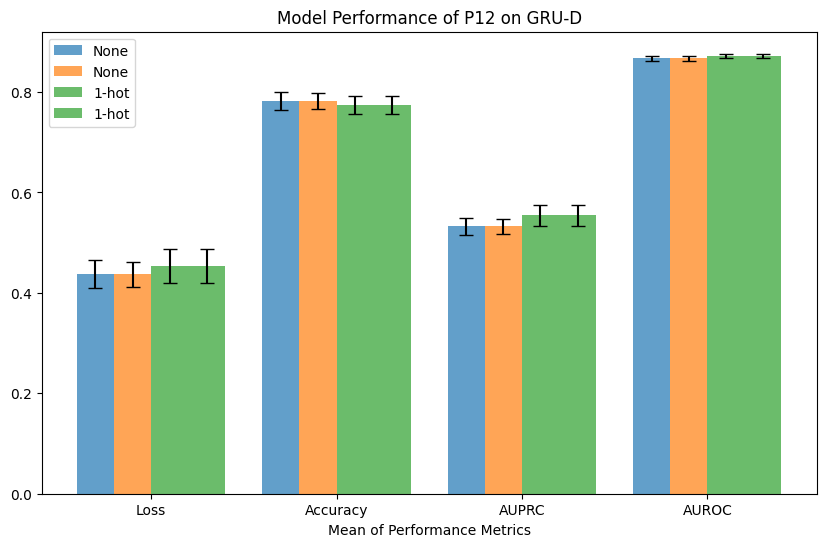

In [7]:
import json
import numpy as np
import matplotlib.pyplot as plt

# Load JSON data from four files
file1 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_1/summary.json"
file2 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_3/summary.json"
file3 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_2/summary.json"  # New
file4 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_4/summary.json"  # New

with open(file1, "r") as f:
    data1 = json.load(f)
with open(file2, "r") as f:
    data2 = json.load(f)
with open(file3, "r") as f:
    data3 = json.load(f)
with open(file4, "r") as f:
    data4 = json.load(f)

# Extract metrics
metrics = ["mean_loss", "mean_accuracy", "mean_auprc", "mean_auroc"]
std_metrics = ["std_loss", "std_accuracy", "std_auprc", "std_auroc"]

means1 = [data1[m] for m in metrics]
means2 = [data2[m] for m in metrics]
means3 = [data3[m] for m in metrics]
means4 = [data4[m] for m in metrics]

stds1 = [data1[s] for s in std_metrics]
stds2 = [data2[s] for s in std_metrics]
stds3 = [data3[s] for s in std_metrics]
stds4 = [data4[s] for s in std_metrics]

# Plot bar chart
x_labels = ["Loss", "Accuracy", "AUPRC", "AUROC"]
x = np.arange(len(metrics))
width = 0.2  # Adjust width for 4 bars

fig, ax = plt.subplots(figsize=(10, 6))

colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # Blue, Orange, Green, Red

bars1 = ax.bar(x - 1.5 * width, means1, width, yerr=stds1, capsize=5, label="None", alpha=0.7, color=colors[0])
bars2 = ax.bar(x - 0.5 * width, means2, width, yerr=stds2, capsize=5, label="None", alpha=0.7, color=colors[1])
bars3 = ax.bar(x + 0.5 * width, means3, width, yerr=stds3, capsize=5, label="1-hot", alpha=0.7, color=colors[2])
bars4 = ax.bar(x + 1.5 * width, means4, width, yerr=stds4, capsize=5, label="1-hot", alpha=0.7, color=colors[2])


# Labels and formatting
ax.set_xlabel("Mean of Performance Metrics")
ax.set_ylabel("")
ax.set_title("Model Performance of P12 on GRU-D")
ax.set_xticks(x)
ax.set_xticklabels(x_labels)
ax.legend()

plt.show()


In [10]:
# Load JSON data from four files
file1 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_3/summary.json"
file2 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_5/summary.json"
file3 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_2/summary.json"  # New
file4 = "/zhome/be/1/138857/EHR_sensor_representations/output/run_4/summary.json"  # New

with open(file1, "r") as f:
    data1 = json.load(f)
with open(file2, "r") as f:
    data2 = json.load(f)
with open(file3, "r") as f:
    data3 = json.load(f)
with open(file4, "r") as f:
    data4 = json.load(f)

# Extract metrics
metrics = ["mean_loss", "mean_accuracy", "mean_auprc", "mean_auroc"]
std_metrics = ["std_loss", "std_accuracy", "std_auprc", "std_auroc"]

means1 = [data1[m] for m in metrics]
means2 = [data2[m] for m in metrics]
means3 = [data3[m] for m in metrics]
means4 = [data4[m] for m in metrics]

stds1 = [data1[s] for s in std_metrics]
stds2 = [data2[s] for s in std_metrics]
stds3 = [data3[s] for s in std_metrics]
stds4 = [data4[s] for s in std_metrics]

print(means1[1], means2[1], means3[1], means4[1])

0.7734778982485405 0.7734778982485405 0.7734778982485405 0.7734778982485405


In [21]:
 # assign GPU
if torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"
device = torch.device(dev)

data = torch.rand(2,2,1)

N = data.shape[0]
F = data.shape[1]
T = data.shape[2]

one_hot = torch.eye(F, device=device).flatten().unsqueeze(0).unsqueeze(2)
one_hot = torch.cat([one_hot] * N, dim=0)
one_hot = torch.cat([one_hot] * T, dim=2)

In [174]:

def get_one_hot_features(data, device):

    # Identity matrix for one-hot encoding (F, F)
    N = data.shape[0]
    F = data.shape[1]
    T = data.shape[2]

    one_hot = torch.eye(F, device=device).flatten().unsqueeze(0).unsqueeze(2)
    one_hot = torch.cat([one_hot] * N, dim=0)
    one_hot = torch.cat([one_hot] * T, dim=2)

    # Create a corresponding mask (1s for all one-hot encoded features)
    one_hot_mask = torch.ones_like(one_hot, dtype=torch.float32, device=device)

    # Create a corresponding delta (0s since one-hot encoding does not change over time)
    one_hot_delta = torch.zeros_like(one_hot, dtype=torch.float32, device=device)

    return one_hot, one_hot_mask, one_hot_delta

if torch.cuda.is_available():
    dev = "cuda"
else:
    dev = "cpu"
device = torch.device(dev)

F = 37
data = torch.rand(1,F,3)

one_hot_features ,_ ,_ = get_one_hot_features(data, device = device) 

N = 1
T = 2

data_a = torch.round(torch.cat([data, one_hot_features], dim=1), decimals=1)

print(data_a.shape)
#test_list = [f"{x:.1f}" for x in data_a[N,:F+(F*F),T].tolist()]

#for i in range(0,len(test_list),F):
#    print(test_list[i:i+F])


torch.Size([1, 1406, 3])


In [ ]:
output_path = "/zhome/be/1/138857/EHR_sensor_representations/output/"
run = "run_1/"
split = "split_2/"
path = output_path + run + split

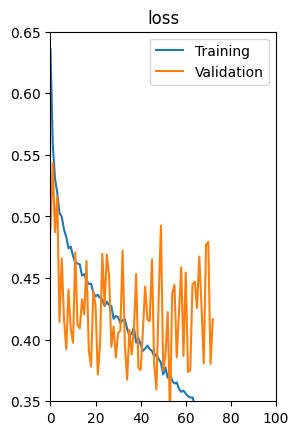

In [22]:
import pandas as pd
import matplotlib.pyplot as plt

output_path = "/zhome/be/1/138857/EHR_sensor_representations/output/"
run = "run_17/"
split = "split_5/"
path = output_path + run + split
training_log = pd.read_csv(f"{path}/training_log.csv")

fig = plt.figure()

ax0 = fig.add_subplot(121, title="loss")
ax0.plot(training_log["train_loss"], label="Training")
ax0.plot(training_log["val_loss"], label="Validation")
ax0.set_xlim(0, 100)     
ax0.set_ylim(0.35, 0.65)  
ax0.legend()
plt.show()


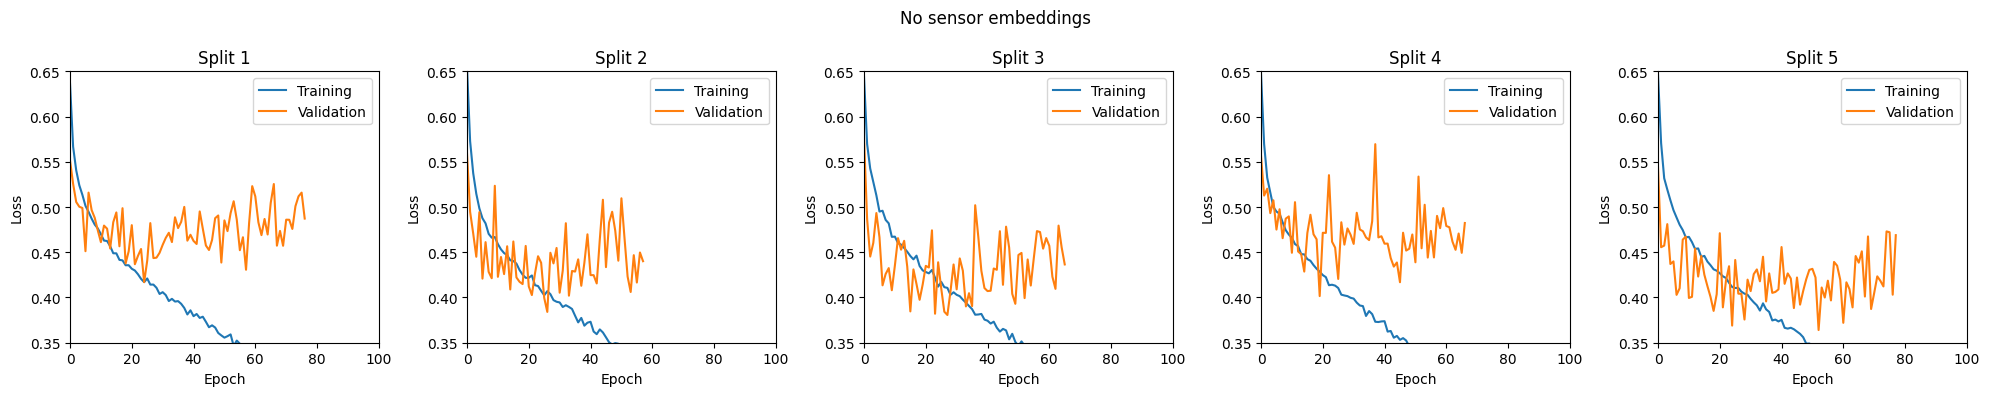

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# === Settings ===
output_path = "/zhome/be/1/138857/EHR_sensor_representations/output/"
run = "run_´3/"
num_splits = 5  # Number of splits to plot

sensor_type = "No sensor embeddings"
#sensor_type = "One-hot sensor embeddings"
#sensor_type = "LLM sensor embeddings"

# === Create figure with 5 subplots side-by-side ===
fig, axes = plt.subplots(1, num_splits, figsize=(20, 4))  # 1 row, 5 columns
fig.suptitle(f"{sensor_type}")

for i in range(num_splits):
    split = f"split_{i+1}/"
    path = output_path + run + split + "training_log.csv"
    
    try:
        training_log = pd.read_csv(path)
        ax = axes[i]
        ax.plot(training_log["train_loss"], label="Training")
        ax.plot(training_log["val_loss"], label="Validation")
        ax.set_title(f"Split {i+1}")
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Loss")
        ax.set_xlim(0, 100)
        ax.set_ylim(0.35, 0.65)
        ax.legend()
    except FileNotFoundError:
        print(f"Warning: File not found for {split}")
        axes[i].set_title(f"Split {i+1} (missing)")
        axes[i].axis("off")

plt.tight_layout()
plt.show()


In [4]:
from sentence_transformers import SentenceTransformer

In [5]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer("abhinand/MedEmbed-small-v0.1")

ts_features = [
    'Weight', 'ALP', 'ALT', 'AST', 'Albumin', 'BUN', 'Bilirubin',
    'Cholesterol', 'Creatinine', 'DiasABP', 'FiO2', 'GCS', 'Glucose',
    'HCO3', 'HCT', 'HR', 'K', 'Lactate', 'MAP', 'MechVent', 'Mg',
    'NIDiasABP', 'NIMAP', 'NISysABP', 'Na', 'PaCO2', 'PaO2', 'Platelets',
    'RespRate', 'SaO2', 'SysABP', 'Temp', 'TroponinI', 'TroponinT',
    'Urine', 'WBC', 'pH'
]

embeddings = model.encode(ts_features)

similarities = model.similarity(embeddings, embeddings)
print(similarities.shape)
# [3, 3]



torch.Size([37, 37])


In [9]:
import numpy as np
np.shape(embeddings)

(37, 384)

Epoch 1/100 — Train Loss: 0.0054, Val Loss: 0.0040
Epoch 10/100 — Train Loss: 0.0011, Val Loss: 0.0010
Epoch 20/100 — Train Loss: 0.0011, Val Loss: 0.0010
Epoch 30/100 — Train Loss: 0.0009, Val Loss: 0.0010
Epoch 40/100 — Train Loss: 0.0010, Val Loss: 0.0010
Epoch 50/100 — Train Loss: 0.0008, Val Loss: 0.0010
Epoch 60/100 — Train Loss: 0.0008, Val Loss: 0.0010
Epoch 70/100 — Train Loss: 0.0007, Val Loss: 0.0010
Epoch 80/100 — Train Loss: 0.0006, Val Loss: 0.0009
Epoch 90/100 — Train Loss: 0.0005, Val Loss: 0.0009
Epoch 100/100 — Train Loss: 0.0006, Val Loss: 0.0010


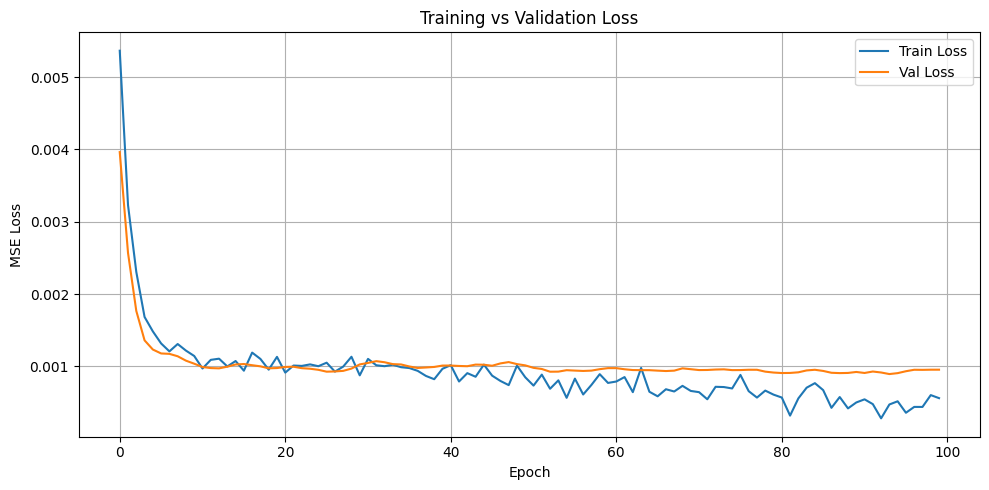

In [97]:
# Step 1: Install PyTorch if not already installed
# !pip install torch matplotlib

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import matplotlib.pyplot as plt

# Step 2: Load your data
# Replace this with your actual array
#data = np.random.rand(37, 384).astype(np.float32)  # Dummy array
data = embeddings
tensor_data = torch.tensor(data)

# Step 3: Train/val split
val_ratio = 0.2
val_size = int(len(tensor_data) * val_ratio)
train_size = len(tensor_data) - val_size

train_dataset, val_dataset = random_split(tensor_data, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

# Step 4: Define the autoencoder
class Autoencoder(nn.Module):
    def __init__(self, input_dim=384, embedding_dim=37):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, embedding_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim),
        )

    def forward(self, x):
        embedding = self.encoder(x)
        reconstructed = self.decoder(embedding)
        return reconstructed

model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 5: Training loop with validation
num_epochs = 100
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    for batch in train_loader:
        x = batch[0]
        optimizer.zero_grad()
        output = model(x)
        loss = criterion(output, x)
        loss.backward()
        optimizer.step()
        running_train_loss += loss.item()

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0]
            output = model(x)
            loss = criterion(output, x)
            running_val_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)
    avg_val_loss = running_val_loss / len(val_loader)
    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1}/{num_epochs} — Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

# Step 6: Plot training & validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [27]:
import itertools
from sklearn.metrics.pairwise import cosine_similarity

def cosine_similarity_score(y_true, y_pred):
    similarities = []
    for i in range(len(y_true)):
        sim = cosine_similarity(y_true[i].reshape(1, -1), y_pred[i].reshape(1, -1))[0][0]
        similarities.append(sim)
    return np.mean(similarities)

def train_autoencoder(
    data,
    embedding_dim=37,
    hidden_dim=128,
    learning_rate=0.001,
    num_epochs=100,
    batch_size=8,
    verbose=False
):
    tensor_data = torch.tensor(data).float()

    # Split data
    val_ratio = 0.2
    val_size = int(len(tensor_data) * val_ratio)
    train_size = len(tensor_data) - val_size
    train_dataset, val_dataset = random_split(tensor_data, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Model
    class Autoencoder(nn.Module):
        def __init__(self):
            super(Autoencoder, self).__init__()
            self.encoder = nn.Sequential(
                nn.Linear(tensor_data.shape[1], hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, embedding_dim),
            )
            self.decoder = nn.Sequential(
                nn.Linear(embedding_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, tensor_data.shape[1]),
            )

        def forward(self, x):
            embedding = self.encoder(x)
            reconstructed = self.decoder(embedding)
            return reconstructed

    model = Autoencoder()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            x = batch[0]
            optimizer.zero_grad()
            output = model(x)
            loss = criterion(output, x)
            loss.backward()
            optimizer.step()

    # Evaluate
    model.eval()
    y_true_val, y_pred_val = [], []
    with torch.no_grad():
        for batch in val_loader:
            x = batch[0]
            output = model(x)
            y_true_val.append(x.numpy())
            y_pred_val.append(output.numpy())

    y_true_val = np.vstack(y_true_val)
    y_pred_val = np.vstack(y_pred_val)

    val_cosine = cosine_similarity_score(y_true_val, y_pred_val)

    if verbose:
        print(f"Val Cosine Sim: {val_cosine:.4f} | "
              f"Emb: {embedding_dim}, Hidden: {hidden_dim}, LR: {learning_rate}, Epochs: {num_epochs}")

    return val_cosine


In [99]:
# Define hyperparameter grid
embedding_dims = [37]
hidden_dims = [64, 32]
learning_rates = [0.005, 0.001]
epoch_list = [400, 500]

# Store results
results = []

# Loop over all combinations
for emb_dim, hid_dim, lr, epochs in itertools.product(embedding_dims, hidden_dims, learning_rates, epoch_list):
    cosine = train_autoencoder(
        data=embeddings,
        embedding_dim=emb_dim,
        hidden_dim=hid_dim,
        learning_rate=lr,
        num_epochs=epochs,
        verbose=True
    )
    results.append({
        "embedding_dim": emb_dim,
        "hidden_dim": hid_dim,
        "learning_rate": lr,
        "epochs": epochs,
        "val_cosine": cosine
    })

# Sort results by best cosine similarity
sorted_results = sorted(results, key=lambda x: x["val_cosine"], reverse=True)

# Print top 5 configs
print("\nTop 5 configurations (by cosine similarity):")
for res in sorted_results[:5]:
    print(res)


Val Cosine Sim: 0.9037 | Emb: 37, Hidden: 64, LR: 0.005, Epochs: 400
Val Cosine Sim: 0.7430 | Emb: 37, Hidden: 64, LR: 0.005, Epochs: 500
Val Cosine Sim: 0.8029 | Emb: 37, Hidden: 64, LR: 0.001, Epochs: 400
Val Cosine Sim: 0.8020 | Emb: 37, Hidden: 64, LR: 0.001, Epochs: 500
Val Cosine Sim: 0.7331 | Emb: 37, Hidden: 32, LR: 0.005, Epochs: 400
Val Cosine Sim: 0.7689 | Emb: 37, Hidden: 32, LR: 0.005, Epochs: 500
Val Cosine Sim: 0.7911 | Emb: 37, Hidden: 32, LR: 0.001, Epochs: 400
Val Cosine Sim: 0.8172 | Emb: 37, Hidden: 32, LR: 0.001, Epochs: 500

Top 5 configurations (by cosine similarity):
{'embedding_dim': 37, 'hidden_dim': 64, 'learning_rate': 0.005, 'epochs': 400, 'val_cosine': 0.90371394}
{'embedding_dim': 37, 'hidden_dim': 32, 'learning_rate': 0.001, 'epochs': 500, 'val_cosine': 0.8171526}
{'embedding_dim': 37, 'hidden_dim': 64, 'learning_rate': 0.001, 'epochs': 400, 'val_cosine': 0.8029076}
{'embedding_dim': 37, 'hidden_dim': 64, 'learning_rate': 0.001, 'epochs': 500, 'val_cosin

In [ ]:
{'embedding_dim': 37, 'hidden_dim': 64, 'learning_rate': 0.001, 'epochs': 400, 'val_cosine': 0.91707903}
{'embedding_dim': 37, 'hidden_dim': 64, 'learning_rate': 0.001, 'epochs': 300, 'val_cosine': 0.8792403}
{'embedding_dim': 37, 'hidden_dim': 64, 'learning_rate': 0.001, 'epochs': 300, 'val_cosine': 0.87686783}
{'embedding_dim': 37, 'hidden_dim': 128, 'learning_rate': 0.001, 'epochs': 200, 'val_cosine': 0.86700284}
{'embedding_dim': 37, 'hidden_dim': 32, 'learning_rate': 0.001, 'epochs': 400, 'val_cosine': 0.85669523}
{'embedding_dim': 37, 'hidden_dim': 128, 'learning_rate': 0.001, 'epochs': 100, 'val_cosine': 0.8364941}

In [70]:
import numpy as np

# New dimensions
N = 3       # patients
F = 37      # features
T = 2       # timepoints

# Simulate some fake data: shape (N, F, T)
np.random.seed(42)
data = np.random.randint(50, 150, size=(N, F, T))  # e.g., mock sensor readings

# Create identity matrix for one-hot sensor encoding: (F, F)
identity = np.eye(F)

# Output container: (N, T, F × (1 + F)) = (3, 2, 1406)
augmented = np.zeros((N, T, F * (1 + F)))

for f in range(F):
    for i in range(N):
        for t in range(T):
            start_idx = f * (1 + F)
            augmented[i, t, start_idx] = data[i, f, t]                   # feature value
            augmented[i, t, start_idx + 1 : start_idx + 1 + F] = identity[f]  # one-hot ID

# Check result
print("Final augmented shape:", augmented.shape)  # (3, 2, 1406)
print("\nPatient 1 - Time 1 (first 10 elements):")
print(augmented[0, 0][:100])  # just to preview


Final augmented shape: (3, 2, 1406)

Patient 1 - Time 1 (first 10 elements):
[101.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.  64.   0.   1.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0. 110.   0.   0.   1.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.]


In [75]:
import torch

# Dimensions
N = 3   # patients
F = 37  # features
T = 1   # timepoints

# Measurements: 10 < x < 100
data = torch.randint(11, 100, (N, F, T)).float()

# Random binary mask (0 or 1)
mask = torch.randint(0, 2, (N, F, T)).float()

# Deltas: 0 < x < 1
delta = torch.rand(N, F, T)  # already in [0,1)

# Print samples
print("Data[0,:,0] (Patient 1 measurements):\n", data[0, :, 0])
print("\nMask[0,:,0] (Patient 1):\n", mask[0, :, 0])
print("\nDelta[0,:,0] (Patient 1):\n", delta[0, :, 0])


Data[0,:,0] (Patient 1 measurements):
 tensor([14., 59., 51., 91., 23., 85., 65., 18., 69., 26., 49., 89., 79., 86.,
        24., 50., 58., 52., 23., 60., 78., 47., 88., 91., 54., 42., 96., 40.,
        88., 71., 95., 30., 12., 81., 63., 68., 95.])

Mask[0,:,0] (Patient 1):
 tensor([1., 0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1.,
        0.])

Delta[0,:,0] (Patient 1):
 tensor([0.3233, 0.1109, 0.1321, 0.1134, 0.5875, 0.4080, 0.5688, 0.0689, 0.2235,
        0.2996, 0.5434, 0.8160, 0.9136, 0.8548, 0.0192, 0.1648, 0.2852, 0.0109,
        0.2477, 0.2694, 0.9525, 0.7259, 0.2514, 0.6436, 0.2896, 0.9369, 0.0560,
        0.6152, 0.2066, 0.0014, 0.9631, 0.2425, 0.8413, 0.9456, 0.0327, 0.4807,
        0.3224])


In [76]:
import torch

def augment_with_sensor_identity(data, mask, delta):
    """
    Augments data, mask, and delta by adding per-feature one-hot identities.
    
    Inputs:
        data, mask, delta: tensors of shape (N, F, T)
        
    Returns:
        augmented_data, augmented_mask, augmented_delta: shape (N, F*(1+F), T)
    """
    N, F, T = data.shape
    device = data.device

    # Prepare output tensors
    out_dim = F * (1 + F)
    augmented_data = torch.zeros((N, out_dim, T), device=device)
    augmented_mask = torch.zeros_like(augmented_data)
    augmented_delta = torch.zeros_like(augmented_data)

    identity = torch.eye(F, device=device)  # (F, F)

    for f in range(F):
        base = f * (1 + F)

        # Insert measurement
        augmented_data[:, base, :] = data[:, f, :]
        augmented_mask[:, base, :] = mask[:, f, :]
        augmented_delta[:, base, :] = delta[:, f, :]

        # Insert one-hot vector for that feature
        one_hot_vec = identity[f]  # shape (F,)
        one_hot_expanded = one_hot_vec.view(1, F, 1).expand(N, F, T)  # (N, F, T)

        augmented_data[:, base + 1 : base + 1 + F, :] = one_hot_expanded
        augmented_mask[:, base + 1 : base + 1 + F, :] = 1.0
        augmented_delta[:, base + 1 : base + 1 + F, :] = 0.0

    return augmented_data, augmented_mask, augmented_delta


In [77]:
da,m,de = augment_with_sensor_identity(data, mask, delta)

In [84]:
# Assume you already ran:
# aug_data, aug_mask, aug_delta = augment_with_sensor_identity(da, mask, delta)

F = 37
block_size = 1 + F  # 38
feature_idx = 5     # 5th measurement (index 4)
patient_idx = 0
time_idx = 0

start = feature_idx * block_size
end = start + block_size

# Extract from augmented data
block_data = da[patient_idx, start:end, time_idx]
block_mask = m[patient_idx, start:end, time_idx]
block_delta = de[patient_idx, start:end, time_idx]

print(block_data)

print(block_mask)

print(block_delta)


tensor([85.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])
tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1.])
tensor([0.4080, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000])


In [81]:
block

tensor([23.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [72]:
F = 37
block_size = 1 + F  # 38
feature_idx = 4     # 5th measurement (index 4)
patient_idx = 0
time_idx = 0

start = feature_idx * block_size
end = start + block_size

block = augmented[patient_idx, time_idx, start:end]

value = block[0]
one_hot = block[1:]

print(f"Patient 1 - Time 1 - Feature {feature_idx + 1}")
print("Measurement:", value)
print("Sensor identity (one-hot):", one_hot)


Patient 1 - Time 1 - Feature 5
Measurement: 124.0
Sensor identity (one-hot): [0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [ ]:
for i in range(len(augmented[0,0])):
    if i / 37 == 0: 
        print(augmented[0,0][i])

101.0


## Dim reduction tests

In [144]:
from sklearn.decomposition import PCA
print("Shape before PCA:", embeddings.shape)
pca = PCA(n_components=37)
reduced_embeddings = pca.fit_transform(embeddings)
print("Shape after PCA:", reduced_embeddings.shape)
explained_variance = sum(pca.explained_variance_ratio_)
print(f"Variance retained: {explained_variance:.2%}")


Shape before PCA: (37, 384)
Shape after PCA: (37, 37)
Variance retained: 100.00%


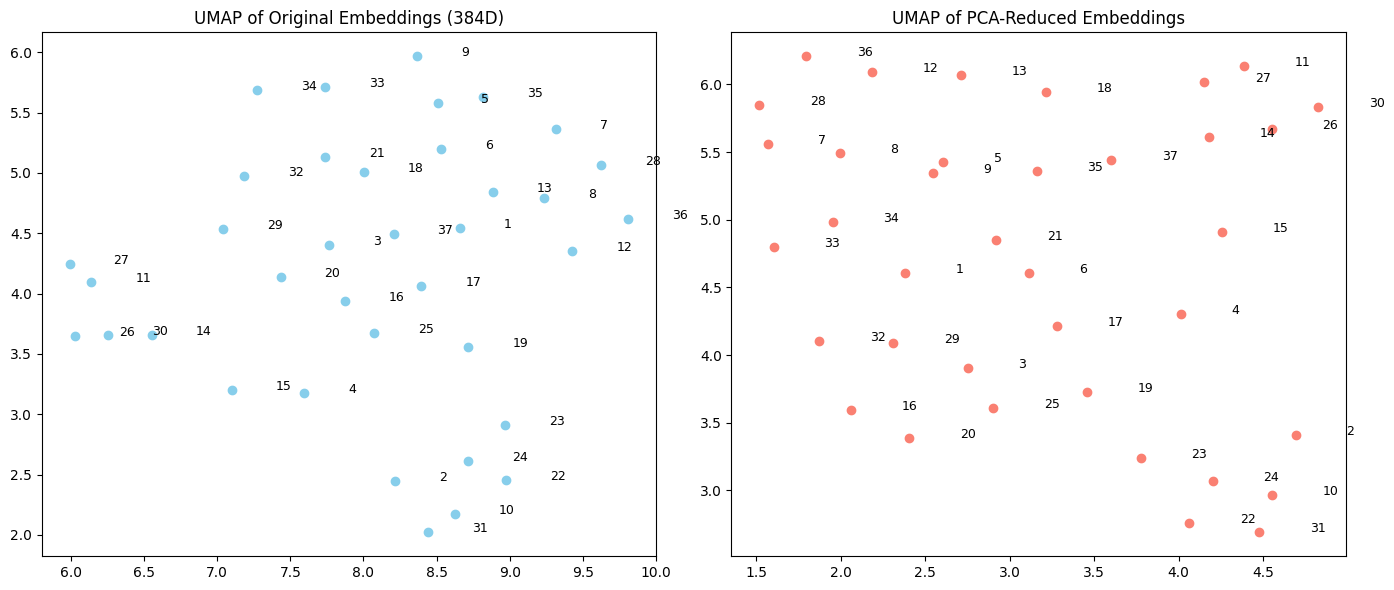

In [146]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# UMAP reducer
reducer = umap.UMAP(n_components=2, random_state=42)

# Fit and transform both sets
original_umap = reducer.fit_transform(original_embeddings)
reduced_umap = reducer.fit_transform(reduced_embeddings)

# Plot side by side
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot original
axs[0].scatter(original_umap[:, 0], original_umap[:, 1], color='skyblue')
for i, (x, y) in enumerate(original_umap):
    axs[0].text(x + 0.3, y, str(i + 1), fontsize=9)
axs[0].set_title('UMAP of Original Embeddings (384D)')

# Plot reduced
axs[1].scatter(reduced_umap[:, 0], reduced_umap[:, 1], color='salmon')
for i, (x, y) in enumerate(reduced_umap):
    axs[1].text(x + 0.3, y, str(i + 1), fontsize=9)
axs[1].set_title('UMAP of PCA-Reduced Embeddings')

plt.tight_layout()
plt.show()


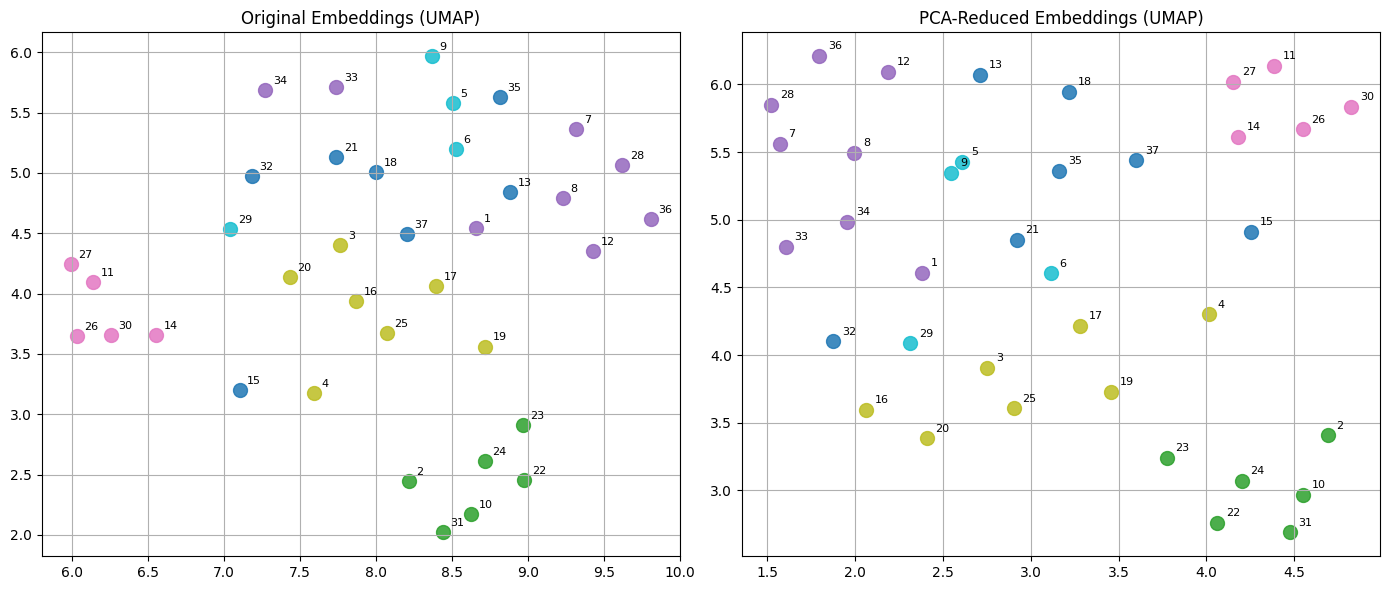

In [153]:
import numpy as np
import matplotlib.pyplot as plt
import umap
from sklearn.cluster import KMeans
import matplotlib.cm as cm

# --- UMAP ---
reducer = umap.UMAP(n_components=2, random_state=42)
original_umap = reducer.fit_transform(original_embeddings)
reduced_umap = reducer.fit_transform(reduced_embeddings)

# --- Clustering on original embeddings ---
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(original_embeddings)

# --- Colormap for clusters ---
colors = cm.tab10(cluster_labels / (n_clusters - 1))  # Normalize for colormap

# --- Plot ---
fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plot Original
axs[0].set_title('Original Embeddings (UMAP)', fontsize=12)
for i in range(len(original_umap)):
    axs[0].scatter(original_umap[i, 0], original_umap[i, 1],
                   color=colors[i], s=100, alpha=0.85)
    axs[0].text(original_umap[i, 0] + 0.05, original_umap[i, 1] + 0.05,
                str(i + 1), fontsize=8)

axs[0].grid(True)

# Plot Reduced
axs[1].set_title('PCA-Reduced Embeddings (UMAP)', fontsize=12)
for i in range(len(reduced_umap)):
    axs[1].scatter(reduced_umap[i, 0], reduced_umap[i, 1],
                   color=colors[i], s=100, alpha=0.85)
    axs[1].text(reduced_umap[i, 0] + 0.05, reduced_umap[i, 1] + 0.05,
                str(i + 1), fontsize=8)

axs[1].grid(True)

plt.tight_layout()
plt.show()


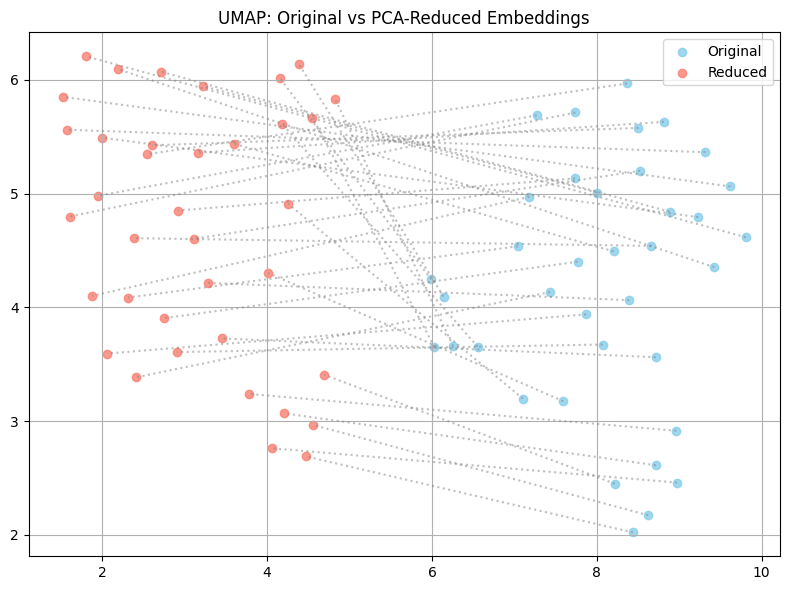

In [147]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Run UMAP on both original and reduced embeddings
reducer = umap.UMAP(n_components=2, random_state=42)

original_umap = reducer.fit_transform(original_embeddings)
reduced_umap = reducer.fit_transform(reduced_embeddings)

# Plot setup
plt.figure(figsize=(8, 6))

# Plot original points
plt.scatter(original_umap[:, 0], original_umap[:, 1], color='skyblue', label='Original', alpha=0.8)

# Plot reduced points
plt.scatter(reduced_umap[:, 0], reduced_umap[:, 1], color='salmon', label='Reduced', alpha=0.8)

# Draw dotted lines between matching word embeddings
for i in range(len(original_umap)):
    x_vals = [original_umap[i, 0], reduced_umap[i, 0]]
    y_vals = [original_umap[i, 1], reduced_umap[i, 1]]
    plt.plot(x_vals, y_vals, linestyle='dotted', color='gray', alpha=0.5)

# Styling
plt.title('UMAP: Original vs PCA-Reduced Embeddings')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [141]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming: embeddings.shape = (37, 384)
# Replace with your actual embeddings variable
# embeddings = ...

explained_variances = []
component_range = range(2, 50)  # from 2 to 37 inclusive

for n in component_range:
    pca = PCA(n_components=n)
    pca.fit(embeddings)
    explained_var = np.sum(pca.explained_variance_ratio_)
    explained_variances.append(explained_var)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(component_range, explained_variances, marker='o')
plt.xlabel('Number of PCA Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance as Function of PCA Components')
plt.grid(True)
plt.tight_layout()
plt.show()


ValueError: n_components=38 must be between 0 and min(n_samples, n_features)=37 with svd_solver='full'

In [138]:
from sklearn.cluster import KMeans
from collections import defaultdict

# ----- Step 1: Cluster both sets -----
original_embeddings = embeddings
n_clusters = 3

# Cluster original embeddings (384D)
kmeans_orig = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_orig = kmeans_orig.fit_predict(original_embeddings)

# Cluster reduced embeddings (e.g. PCA-reduced, shape [37, 37])
kmeans_reduced = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels_reduced = kmeans_reduced.fit_predict(reduced_embeddings)




In [139]:
print(f"Original embeddings: {cluster_labels_orig}") 
print(f"Reduced embeddings:  {cluster_labels_reduced}") 

Original embeddings: [1 1 1 1 1 1 1 1 1 2 0 1 1 0 1 1 1 1 1 0 1 2 2 2 1 0 0 1 0 0 2 1 1 1 1 1 1]
Reduced embeddings:  [1 1 1 1 1 1 1 1 1 2 0 1 1 0 1 1 1 1 1 0 1 2 2 2 1 0 0 1 0 0 2 1 1 1 1 1 1]


In [116]:
import numpy as np

# File path
embeddings_path = "/zhome/be/1/138857/EHR_sensor_representations/scripts/embeddings/pca_small_embeddings.npy"

# Save as .npy
np.save(embeddings_path, reduced_embeddings)

print(f"✅ Embeddings saved to: {embeddings_path}")


✅ Embeddings saved to: /zhome/be/1/138857/EHR_sensor_representations/scripts/embeddings/pca_small_embeddings.npy


## New embedding model BiomedBERT

In [3]:
from sentence_transformers import SentenceTransformer

#model = SentenceTransformer("abhinand/MedEmbed-small-v0.1")
model = SentenceTransformer("abhinand/MedEmbed-large-v0.1")
# Feature names
ts_features = [
    "Weight [kg]",
    "Alkaline phosphatase [IU/L]",
    "Alanine transaminase [IU/L]",
    "Aspartate transaminase [IU/L]",
    "Albumin [g/dL]",
    "Blood urea nitrogen [mg/dL]",
    "Bilirubin [mg/dL]",
    "Cholesterol [mg/dL]",
    "Serum creatinine [mg/dL]",
    "Invasive diastolic arterial blood pressure [mmHg]",
    "Fractional inspired O2 [0-1]",
    "Glasgow Coma Score [3-15]",
    "Serum glucose [mg/dL]",
    "Serum bicarbonate [mmol/L]",
    "Hematocrit [%]",
    "Heart rate [bpm]",
    "Serum potassium [mEq/L]",
    "Lactate [mmol/L]",
    "Invasive mean arterial blood pressure [mmHg]",
    "Mechanical ventilation respiration [0:false, 1:true]",
    "Serum magnesium [mmol/L]",
    "Non-invasive diastolic arterial blood pressure [mmHg]",
    "Non-invasive mean arterial blood pressure [mmHg]",
    "Non-invasive systolic arterial blood pressure [mmHg]",
    "Serum sodium [mEq/L]",
    "Partial pressure of arterial CO2 [mmHg]",
    "Partial pressure of arterial O2 [mmHg]",
    "Platelets [cells/nL]",
    "Respiration rate [bpm]",
    "O2 saturation in hemoglobin [%]",
    "Invasive systolic arterial blood pressure [mmHg]",
    "Temperature [°C]",
    "Troponin-I [μg/L]",
    "Troponin-T [μg/L]",
    "Urine output [mL]",
    "White blood cell count [cells/nL]",
    "Arterial pH [0-14]"
]

embeddings = model.encode(ts_features)

In [11]:
from sklearn.decomposition import PCA
print("Shape before PCA:", embeddings.shape)
pca = PCA(n_components=37)
reduced_embeddings = pca.fit_transform(embeddings)
print("Shape after PCA:", reduced_embeddings.shape)
explained_variance = sum(pca.explained_variance_ratio_)
print(f"Variance retained: {explained_variance:.2%}")

Shape before PCA: (37, 1024)
Shape after PCA: (37, 37)
Variance retained: 100.00%


/work3/s185395/venv/lib/python3.9/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


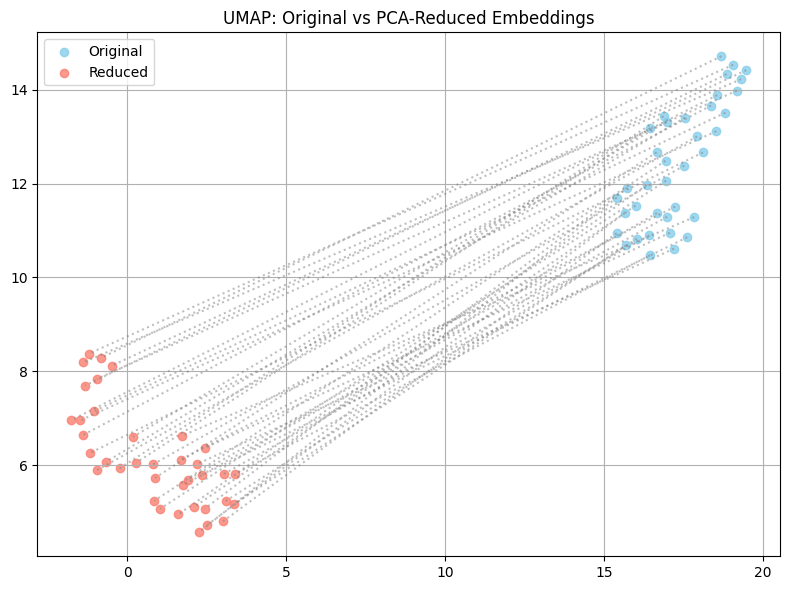

In [12]:
import umap
import matplotlib.pyplot as plt
import numpy as np

# Run UMAP on both original and reduced embeddings
reducer = umap.UMAP(n_components=2, random_state=42)

original_umap = reducer.fit_transform(embeddings)
reduced_umap = reducer.fit_transform(reduced_embeddings)

# Plot setup
plt.figure(figsize=(8, 6))

# Plot original points
plt.scatter(original_umap[:, 0], original_umap[:, 1], color='skyblue', label='Original', alpha=0.8)

# Plot reduced points
plt.scatter(reduced_umap[:, 0], reduced_umap[:, 1], color='salmon', label='Reduced', alpha=0.8)

# Draw dotted lines between matching word embeddings
for i in range(len(original_umap)):
    x_vals = [original_umap[i, 0], reduced_umap[i, 0]]
    y_vals = [original_umap[i, 1], reduced_umap[i, 1]]
    plt.plot(x_vals, y_vals, linestyle='dotted', color='gray', alpha=0.5)

# Styling
plt.title('UMAP: Original vs PCA-Reduced Embeddings')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

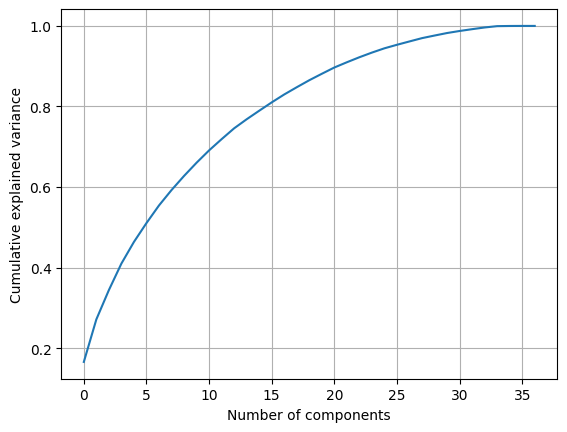

In [7]:
import matplotlib.pyplot as plt

pca = PCA().fit(embeddings)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')
plt.grid(True)
plt.show()


In [8]:
np.cumsum(pca.explained_variance_ratio_)

array([0.16598108, 0.2715655 , 0.34426907, 0.41010898, 0.46380335,
       0.5106107 , 0.55432236, 0.59251636, 0.62759316, 0.66038346,
       0.69101775, 0.71891165, 0.7458164 , 0.768294  , 0.7894337 ,
       0.81019515, 0.82986486, 0.8478056 , 0.8651934 , 0.88117504,
       0.8967707 , 0.90978765, 0.92225546, 0.93380094, 0.94442946,
       0.9531841 , 0.96148854, 0.9696881 , 0.97612154, 0.9823535 ,
       0.98742384, 0.9919186 , 0.9961524 , 0.99945396, 0.999858  ,
       1.        , 1.        ], dtype=float32)

In [ ]:
import numpy as np

# File path
embeddings_path = "/zhome/be/1/138857/EHR_sensor_representations/scripts/embeddings/pca_2_large_embeddings.npy"

# Save as .npy
np.save(embeddings_path, reduced_embeddings)

print(f"✅ Embeddings saved to: {embeddings_path}")